<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Visualizations of Copenhagen subset</h2>
<h4>With plots</h4>
<h4>IT University of Copenhagen, Spring 2022</h4>
<h4>Group: Nina Sand Horup & Ida Thrane</h4>
</div>

In [1]:
# import libraries needed
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon, LineString

# libraries for plotting
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm


%matplotlib inline
ox.__version__

'1.0.1'

# Input parameters

In [2]:
# Input parameters for the small test graph
current_position = (55.6935280, 12.5489348) # Could in practice just come from a GPS location
small_graph_radius = 2500
points_radius_small = small_graph_radius - 1500

Since graph_from_point uses the distance as a 'graph distance' and not a bee-line like the geometries_from_point does, we need to set the radius og the graph to be bigger.

In [3]:
# Plotting parameters

current_position_color = 'red'
restaurant_color = 'magenta' # limegreen
bar_color = 'darkorange'
attraction_color = 'blue'

In [4]:
# Edge cost parameters:

no_go_use = 1000
unwanted_use = 6
speed_cost = 4
anti_nature_cost = 4

In [5]:
# Tags for water/parks 

# Define relevant tags

water_tags = {"waterway": ["riverbank", "canal", "dock"],
        "water": ["river", "canal", "reservoir"],
        "natural": ["bay", "water", "wetland"],
        "place": ["sea", "ocean"]}

park_tags = {"leisure": "park", 
             "landuse": ["cemetery", "meadow", "recreation_ground", "grass"],
             "natural": "wood"}


# Functions

In [25]:
#Change geometries in dataframe to only be points
def gdf_to_only_points(gdf):
    gdf['geometry_init'] = gdf['geometry'] 
    gdf['geometry_init'] = gdf.loc[:, 'geometry']
    
    for i, row in gdf.iterrows():
        if row.geometry.geom_type != "Point":
            new_geometry = row.geometry.centroid
            gdf.at[i, 'geometry'] = new_geometry

In [26]:

# We have the desinations in the form of shapely points and we need the geocoordinates.
def get_coords_from_gdf(gdf):
    geometries =  gdf.geometry
    coords = []
    for geom in geometries: 
        x = geom.x
        y = geom.y
        
        coord = (y,x)
        coords.append(coord)
        
    return coords


# Which OSMIDs do these nodes correspond to, now that we have "simplified" the graph?
# Workaround to use instead of osmnx.distance.nearest_nodes (unavailable in our docker image): 
# https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=digraph#osmnx.distance.nearest_nodes
# here the geodataframe comes in handy for the apply functions:

# Note that these functions are heavily inspired from the exercise 8 solutions


def get_nearest_node(input_coordinate, G):
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True)

    distance = nodes.apply(lambda x: np.sqrt((x.y - input_coordinate[0])**2 + (x.x - input_coordinate[1])**2) , axis = 1)
    output = distance.idxmin()
    return output


def get_nearest_nodes(input_coordinates, G):
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True)
    
    output = []
    for i in range(len(input_coordinates)):
        distances = nodes.apply(lambda x: np.sqrt((x.y - input_coordinates[i][0])**2 + (x.x - input_coordinates[i][1])**2) , axis = 1)
        nearest_node = distances.idxmin()
        output.append(nearest_node)
    return output




In [27]:
# Function to calculate nearest distance to either the big water areas or the big park areas:

def dist_to_nearest_nature(coords, water, parks):
    
    #coords = list(gdf["coordinates"])
    polygons_water = water['geometry']
    polygons_water.reset_index(inplace = True, drop = True)
    
    polygons_parks = parks['geometry']
    polygons_parks.reset_index(inplace = True, drop = True)

    
    # Lists for saving results
    min_distances_to_nature = []
    nature_with_min_dist = []
    nature_type_nearest = []
    
    # Find distance to nearest polygon
    for coord in coords:
        coord = Point(coord[1], coord[0])
        # Water
        dist_to_waters = []
        for poly in polygons_water:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)
                dist_to_waters.append(distance)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)
                dist_to_waters.append(distance)
        dist_to_nearest_water = min(dist_to_waters)
        nearest_water = polygons_water[np.argmin(dist_to_waters)]
        
        # Park areas
        dist_to_parks = []
        
        for poly in polygons_parks:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)
                dist_to_parks.append(distance)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)
                dist_to_parks.append(distance)
        dist_to_nearest_park = min(dist_to_parks)
        nearest_park = polygons_parks[np.argmin(dist_to_parks)]
        
        # Both
        dist_to_nearest_nature = min(dist_to_nearest_water, dist_to_nearest_park)
        min_distances_to_nature.append(dist_to_nearest_nature)
        
        if dist_to_nearest_water < dist_to_nearest_park:
            nature_with_min_dist.append(nearest_water)
            nature_type_nearest.append("water")
        else:
            nature_with_min_dist.append(nearest_park)
            nature_type_nearest.append("park")
    
    return min_distances_to_nature, nature_with_min_dist, nature_type_nearest


**Edge cost functions**

In [28]:
def apply_road_use_cost(G, name_of_cost):
    for edge in G.edges:
        if type(G.edges[edge]["highway"]) == str: #meaning we are not dealing with a list
            current_string = G.edges[edge]["highway"]
            if current_string in no_go_road_types:
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * no_go_use
            if current_string in unwanted_road_types:
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * unwanted_use
            else: 
                G.edges[edge][name_of_cost] = 0
        if type(G.edges[edge]["highway"]) == list:
            current_set = set(G.edges[edge]["highway"])
            if current_set.intersection(no_go_road_types):
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * no_go_use
            if current_set.intersection(no_go_road_types):
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * unwanted_use
            else: 
                G.edges[edge][name_of_cost] = 0


def apply_speed_cost(G, name_of_cost):
    for edge in G.edges:
        if "maxspeed" in G.edges[edge]:
            if (type(G.edges[edge]["maxspeed"]) == list): # Here we take the biggest value, if more than one is listed
                float_list = [float(i) for i in G.edges[edge]["maxspeed"]]
                G.edges[edge][name_of_cost] = max(float_list) * speed_cost
            else: 
                G.edges[edge][name_of_cost] = float(G.edges[edge]["maxspeed"]) * speed_cost
        else:
            G.edges[edge][name_of_cost] = 0


def apply_gain_to_edges_in_polygons(G, geometries, name_of_gain):
    polygons = geometries['geometry']
    
    nodes_in_polygons = []
    
    # Find nodes in polygons with within function from shapely
    
    for node, data in G.nodes(data = True):
        coord = Point(data["x"], data["y"])
        for poly in polygons:
            if coord.within(poly):
                nodes_in_polygons.append(node)
    
    # Apply edge weight to edges with ends in any of these nodes
    for edge in G.edges:
        if (edge[0] in nodes_in_polygons) or (edge[1] in nodes_in_polygons): 
            G.edges[edge][name_of_gain] = 0
        else: 
            G.edges[edge][name_of_gain] = G.edges[edge]["length"] * anti_nature_cost
            
def apply_gain_to_edges_near_polygons(G, geometries, name_of_gain):
    polygons = geometries['geometry']
    
    nodes_near_polygons = []
    
    # Find nodes in polygons with within function from shapely
    
    for node, data in G.nodes(data = True):
        coord = Point(data["x"], data["y"])
        for poly in polygons:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)

                if distance < 0.0005: #If distance is less than 0.5 meters (found empirically to be good)
                    nodes_near_polygons.append(node)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)

                if distance < 0.0005: #If distance is less than 0.5 meters (found empirically to be good)
                    nodes_near_polygons.append(node)
                
    # Apply edge weight to edges with ends in any of these water nodes
    for edge in G.edges:
        if (edge[0] in nodes_near_polygons) or (edge[1] in nodes_near_polygons): 
            G.edges[edge][name_of_gain] = 0
        else: 
            G.edges[edge][name_of_gain] =  G.edges[edge]["length"]* anti_nature_cost
            
def sum_edge_attributes(G, attributes):
    list_total_costs = []
    for u, v, key, data in G.edges(keys=True, data=True): 
        total_cost = 0
        for att in attributes:
            total_cost = total_cost + data[att]
        data["total_cost"] = total_cost
        list_total_costs.append(total_cost)
    return list_total_costs

**Functions for saving and reloading data**

In [29]:
def graph_cols_to_float(G, cols):
    for i, j, key, data in G.edges(keys = True, data = True):
        for col in cols:
            data[col] = float(data[col])

# Import data

### Import small area

In [6]:
%%time
# Import area from address using radius in meters
G_small = ox.graph_from_point(
    current_position,
    dist=small_graph_radius,
    dist_type="network",
    network_type="all",
    simplify = True
)


# We can simplify the graph further by converting to a non-directed. 
# Since the app assumes that the user is on foot (or at least on bike), the one-way roads 
# are not that important

#U_small = ox.utils_graph.get_undirected(G_small) # U is the non-directed graph.
# Note that this takes extra time - does it help us later on?

CPU times: user 17.1 s, sys: 426 ms, total: 17.5 s
Wall time: 17.6 s


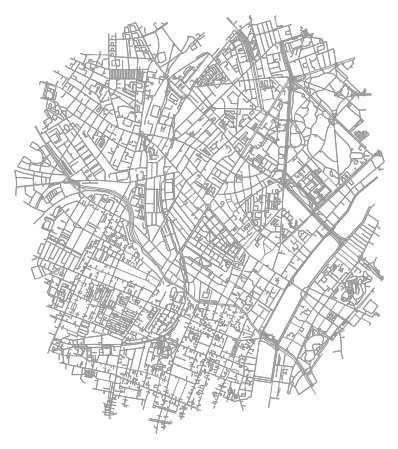

In [7]:
fig, ax = ox.plot_graph(G_small, node_size=0, show = False, close = False, bgcolor = "white");

plt.savefig('./plots/Subset/initial_graph.png')

plt.show()


**Water areas and parks**

In [8]:
# Import water areas

water_small = ox.geometries_from_point(current_position, tags = water_tags, dist=small_graph_radius)

water_polygons_small = water_small["geometry"]



In [9]:
# Import parks

parks_small = ox.geometries_from_point(current_position, tags = park_tags, dist=small_graph_radius)

parks_polygons_small = parks_small["geometry"]

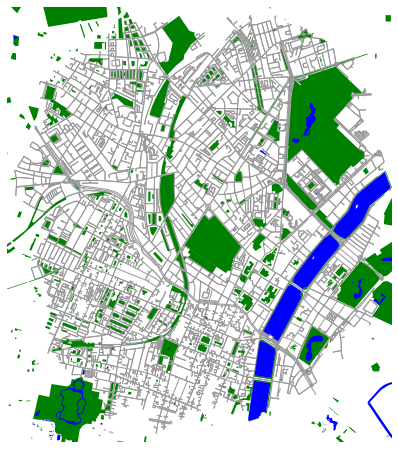

In [11]:
# Plot the water and park areas
fig, ax = ox.plot_graph(G_small, node_size=0, show=False, close=False, bgcolor = 'white');

parks_small.plot(color="green", linewidth=1, ax=ax)

water_small.plot(color="blue", linewidth=1, ax=ax)


plt.savefig('./plots/Subset/water_and_parks.png')



#### Reset names

In [12]:
G = G_small
water = water_small
water_polygons = water_polygons_small
parks = parks_small
parks_polygons = parks_polygons_small

# Create subsets of water and park areas


### Calculating water areas and making subset
We create the subsets by calculating the areas (in square-degrees) and setting a threshold.

In [15]:
area_threshold = 2e-6

In [16]:
# Calculate water areas
water_area_list = []
for poly in water_polygons: 
    area = poly.area
    water_area_list.append(area)

# Add the area information back into the geodataframe

water["area"] = water_area_list

In [17]:
# Create water subset
print("min", min(water_area_list),"max",  max(water_area_list),"mean", np.mean(water_area_list))

water_subset = water[water["area"] > area_threshold]


min 0.0 max 4.7464403254987425e-05 mean 2.5127307818378827e-06


### Calculating park areas and making subset


In [18]:

# Calculate park areas
park_area_list = []
for poly in parks_polygons:
    area = poly.area
    park_area_list.append(area)

# Add the area information back into the geodataframe

parks["area"] = park_area_list



In [19]:
# Create park subset 

print("min", min(park_area_list),"max",  max(park_area_list),"mean", np.mean(park_area_list))

parks_subset = parks[parks["area"] > area_threshold]

min 4.2833999999738956e-10 max 0.00025501229728998575 mean 1.331657767961889e-06


### Plot

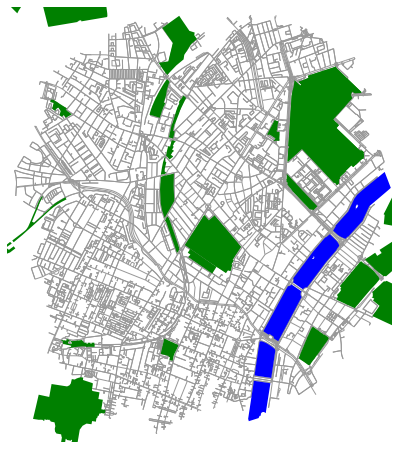

In [20]:

# Plot water subset
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False, bgcolor = 'white');

water_subset.plot(color="blue", linewidth=1, ax=ax)

parks_subset.plot(color="green", linewidth=1, ax=ax)

plt.savefig('./plots/Subset/water_parks_subset.png')

# Preprocessing of destinations

### Choosing a subset of relevant tags

In [21]:
# Three categories of data
restaurants = ox.geometries_from_point(current_position, tags = {"amenity": "restaurant"}, dist=points_radius_small)
bars = ox.geometries_from_point(current_position, tags = {"amenity": "bar"}, dist=points_radius_small)
attractions = ox.geometries_from_point(current_position, tags = {"tourism": True}, dist=points_radius_small)




In [22]:
print("we end up with \n",len(restaurants), "restaurants \n", len(bars), "bars \n", len(attractions), "attractions \n")


we end up with 
 57 restaurants 
 58 bars 
 30 attractions 



### Change geometry to point if it is not already



In [30]:
# Applying function which changes geometries to be only points
gdf_to_only_points(restaurants)
gdf_to_only_points(bars)
gdf_to_only_points(attractions)

### Converting destinations to nodes in the graph

Later, we want to turn our geocoordinates of locations into OSM IDs.
Ideally, we would be using `osmnx.distance.nearest_nodes`. However, our docker is running an outdated OSMnx version where this function does not work (and its predecessor, ` get_nearest_node`, is deprecated). A possible, neither efficient nor elegant but enough-for-our-purposes workaround is to look for the node that minimizes euclidean distance to the location. 

Note that we still want to plot the destionation at its actual location to ensure that the user is not confused.

**Get coordinates**

In [31]:
# Get coords

restaurant_coords = get_coords_from_gdf(restaurants)
bar_coords = get_coords_from_gdf(bars)
attraction_coords = get_coords_from_gdf(attractions)

# Add coordinates back into the gdf's
restaurants["coordinates"] = restaurant_coords
bars["coordinates"] = bar_coords
attractions["coordinates"] = attraction_coords


#### Get nearest OSM ID in the graph

In [32]:
# We first convert the coordinates of our current position into a node:

current_node = get_nearest_node(current_position, G)

**Restaurants**

In [33]:
# Converting the desinations coordinates into nodes which exist on our graph
restaurant_node_ids = get_nearest_nodes(restaurant_coords, G)
restaurant_nodes_and_current_position = restaurant_node_ids + [current_node]

# Add the information back into the gdf
restaurants["nearest node"] = restaurant_node_ids


**Bars**

In [34]:
# Converting the desinations coordinates into nodes which exist on our graph
bar_node_ids = get_nearest_nodes(bar_coords, G)
bar_nodes_and_current_position = bar_node_ids + [current_node]

# Add the information back into the gdf
bars["nearest node"] = bar_node_ids


**Attractions**

In [35]:
# Converting the desinations coordinates into nodes which exist on our graph
attraction_node_ids = get_nearest_nodes(attraction_coords, G)
attraction_nodes_and_current_position = attraction_node_ids + [current_node]

# Add the information back into the gdf
attractions["nearest node"] = attraction_node_ids


**Plot**

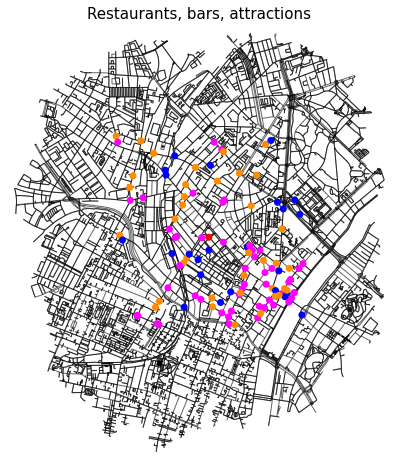

In [36]:

# create node weights 
node_weights = [50 if (node in restaurant_nodes_and_current_position) or (node in bar_nodes_and_current_position) or (node in attraction_nodes_and_current_position) else 0 for node in G.nodes]

node_colours = [current_position_color if node == current_node else restaurant_color if node in restaurant_node_ids else bar_color if node in bar_node_ids else attraction_color if node in attraction_node_ids else 'white' for node in G.nodes]


# Plot

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
fig, ax = ox.plot_graph(G, node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);

ax.set_title("Restaurants, bars, attractions", fontsize = 15)

plt.savefig('./plots/Subset/restaurants_bars_attractions.png')

plt.show()


### Get distance to nearest park/water and get subset

**Get 10 restaurants closest to nature**

In [37]:
restaurants_distances_to_nature, restaurants_nearest_nature, restaurants_nearest_nature_type = dist_to_nearest_nature(list(restaurants["coordinates"]), water_subset, parks_subset)

# Apply to gdf
restaurants["dist_to_nature"] = restaurants_distances_to_nature
restaurants["nearest_nature"] = restaurants_nearest_nature
restaurants["nearest_nature_type"] = restaurants_nearest_nature_type

print("min", min(restaurants_distances_to_nature), "max", max(restaurants_distances_to_nature), "mean", np.mean(restaurants_distances_to_nature))



min 0.00022338416882054508 max 0.0068338319377446105 mean 0.0024208682994075665


**Get 10 bars closest to nature**


In [38]:
bars_distances_to_nature, bars_nearest_nature, bars_nearest_nature_type = dist_to_nearest_nature(list(bars["coordinates"]), water_subset, parks_subset) # Do it for restaurants etc.

# Apply to gdf
bars["dist_to_nature"] = bars_distances_to_nature
bars["nearest_nature"] = bars_nearest_nature
bars["nearest_nature_type"] = bars_nearest_nature_type



**Get 10 attractions closest to nature**


In [39]:
attractions_distances_to_nature, attractions_nearest_nature, attractions_nearest_nature_type = dist_to_nearest_nature(list(attractions["coordinates"]), water_subset, parks_subset) # Do it for restaurants etc.

# Apply to gdf
attractions["dist_to_nature"] = attractions_distances_to_nature
attractions["nearest_nature"] = attractions_nearest_nature
attractions["nearest_nature_type"] = attractions_nearest_nature_type



**Get indexes**

If top 10:


In [40]:
# Get the indexes of the 10 destinations closest to nature: 

indexes_restaurants = np.argsort(restaurants_distances_to_nature)[:10]

restaurant_node_ids_nature = np.array(restaurant_node_ids)[indexes_restaurants] 

restaurant_node_ids_nature_and_current_position = np.append(restaurant_node_ids_nature, current_node)


# Get the indexes of the 10 bars closest to nature: 

indexes_bars = np.argsort(bars_distances_to_nature)[:10]

bar_node_ids_nature = np.array(bar_node_ids)[indexes_bars] 

bar_node_ids_nature_and_current_position = np.append(bar_node_ids_nature, current_node)



# Get the indexes of the 10 bars closest to nature: 

indexes_attractions = np.argsort(attractions_distances_to_nature)[:10]

attraction_node_ids_nature = np.array(attraction_node_ids)[indexes_attractions] 

attraction_node_ids_nature_and_current_position = np.append(attraction_node_ids_nature, current_node)




**Plot**

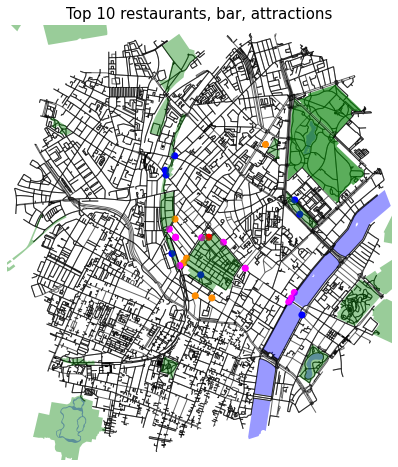

In [41]:
# Plotting all top 10 

# create node weights 
node_weights = [50 if (node in restaurant_node_ids_nature_and_current_position) or (node in bar_node_ids_nature_and_current_position) or (node in attraction_node_ids_nature_and_current_position) else 0 for node in G.nodes]

node_colours = [current_position_color if node == current_node else restaurant_color if node in restaurant_node_ids_nature else bar_color if node in bar_node_ids_nature else attraction_color if node in attraction_node_ids_nature else 'white' for node in G.nodes]

# Plot

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
fig, ax = ox.plot_graph(G, node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);

water_subset.plot(color="blue", linewidth=1, ax=ax, alpha = 0.4)
parks_subset.plot(color="green", linewidth=1, ax=ax, alpha = 0.4)


ax.set_title("Top 10 restaurants, bar, attractions", fontsize = 15)

plt.savefig('./plots/Subset/top10_restaurants_bars_attractions.png')
    
plt.show()


# Preprocessing edges

In order to create nicer routes, we create route attributes which encourage the algorithm to choose routes based on other things than just the length of the route. 

We choose to use the following attributes:

- What is the primary use of the road
- What is the speed limit
- Is the edge in a green area?
- Is the edge near water?

### Road use cost

Adding cost which takes into account the use of the road

The roads we for all costs want to avoid are:

- 'motorway'
- 'motorway_link'
- 'primary'
- 'primary_link'

The roads we would like to avoid are: 

- 'secondary'
- 'secondary_link'
- 'tertiary'
- 'tertiary_link'


In [42]:
# Let's make a function for applying the cost of the road use

no_go_road_types = ['motorway','motorway_link','trunk','primary','primary_link']
unwanted_road_types = ['secondary','secondary_link','tertiary','tertiary_link']


In [43]:
# Let's try to apply it using the function

apply_road_use_cost(G, "use_cost")

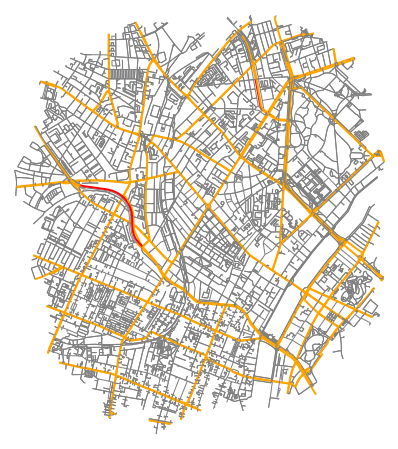

In [44]:
# Let's plot where the highway_cost is over 0 (after applying it)

highway_cost_linewidth = [2 if data["use_cost"] > 0 else 1 for u, v, key, data in G.edges(keys=True, data=True)]
highway_cost_colour = ["r" if data["use_cost"] > 2000 else "orange" if data["use_cost"] > 0 else "grey" for u, v, key, data in G.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(G, node_size=0, edge_color=highway_cost_colour, edge_linewidth=highway_cost_linewidth, edge_alpha=1, bgcolor = "white", show = False, close = False)

plt.savefig('./plots/Subset/road_use_cost_applied.png')

plt.show()
    

### Road speed cost

We add an extra cost to roads which scale with the speed limit. The reason we do this, is that the road use cost mostly targets the biggest roads, and in this way we can also target medium roads. But the cost will be smaller now than in the road use cost.

We found that the difficult part here was that sometime the max_speed is listed as a list. This is probably due to the fact that OSMnx sinplifies the network, and that some edge attributes can be concatenated into a list if they are different. We choose to just use the biggest value in the list as the ground truth. 

This is taken care of in our road speed cost function.

In [45]:
# Let's use the function

apply_speed_cost(G, "speed_cost")

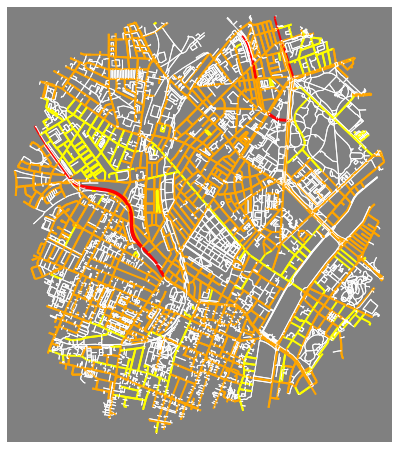

In [46]:
# Let's plot where the speed_cost is over 0 (after applying it)

highway_cost_linewidth = [2 if data["speed_cost"] > 0 else 1 for u, v, key, data in G.edges(keys=True, data=True)]
speed_cost_colour = ["yellow" if (data["speed_cost"] > 0 and data["speed_cost"] < 200) else "orange" if data["speed_cost"] == 200 else "red" if data["speed_cost"] > 50 else "w" for u, v, key, data in G.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(G, node_size=0, edge_color=speed_cost_colour, edge_linewidth=highway_cost_linewidth, edge_alpha=1, bgcolor = "grey", show = False, close = False)

plt.savefig('./plots/Subset/speed_use_cost_applied.png')

plt.show()

### Lower cost for water and green areas



In [47]:
apply_gain_to_edges_in_polygons(G, parks, "park_gain")

In [48]:
apply_gain_to_edges_near_polygons(G, water, "water_gain")

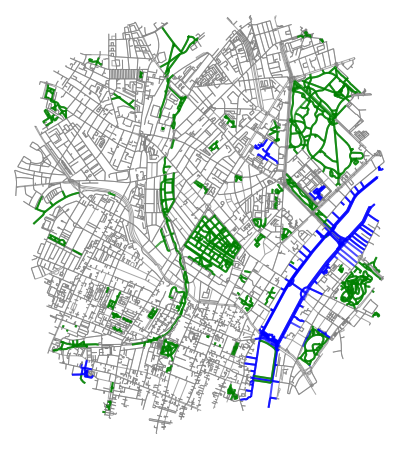

In [54]:
# Let's plot the park and water gain

park_gain_linewidth = [2 if (data["park_gain"] == 0) or (data["water_gain"] == 0) else 1 for u, v, key, data in G.edges(keys=True, data=True)]
park_gain_colour = ["green" if data["park_gain"] == 0 else "blue" if data["water_gain"] == 0 else "grey" for u, v, key, data in G.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(G, node_size=0, edge_color=park_gain_colour, edge_linewidth=park_gain_linewidth, edge_alpha=0.7, bgcolor = "white", show = False, close = False)

plt.savefig('./plots/Subset/park_water_gain_cost_applied.png')

plt.show()


### Adding all the edge attributes together

In [49]:
attributes = ['length', 'use_cost', 'speed_cost', 'park_gain', 'water_gain']


In [50]:
list_total_costs = sum_edge_attributes(G, attributes)


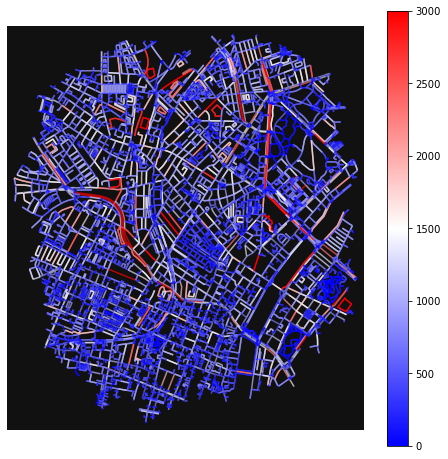

In [51]:
# Making colour scale
norm = matplotlib.colors.Normalize(vmin=0, vmax=3000)
cmap = cm.bwr
m = cm.ScalarMappable(norm=norm, cmap=cmap)

edge_cost_colors = [m.to_rgba(data["total_cost"]) for u, v, key, data in G.edges(keys=True, data=True)]

# Plotting the figure
    
fig, ax = ox.plot_graph(G, node_size=0, edge_color=edge_cost_colors, edge_linewidth=1.5, edge_alpha=0.7,show=False, close=False)

fig.colorbar(m, ax = ax, orientation='vertical')
plt.show()